--- 1. Конфігурація Проєкту ---
✅ Created working directory: race_publica_data

--- 3. Налаштування Sentinel Hub Credentials ---
✅ Sentinel Hub configuration for CDSE successfully set.

--- 4. Завантаження True Color (RGB) ---
✅ True Color Image obtained with shape: (124, 228, 3)
✅ Raster data saved as: race_publica_data/s2_rgb_berlin.tif


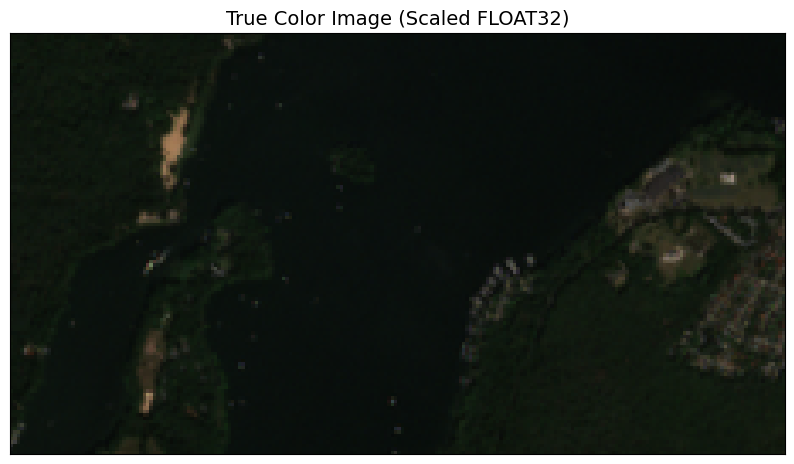

✅ Visualization saved as: race_publica_data/s2_rgb_visual.png

--- 5. Завантаження GeoJSON Водних Шляхів (OSM) ---
⏳ Downloading waterway data for Berlin, Germany...
✅ Векторні дані збережено. Об'єктів: 3042


<Figure size 640x480 with 0 Axes>

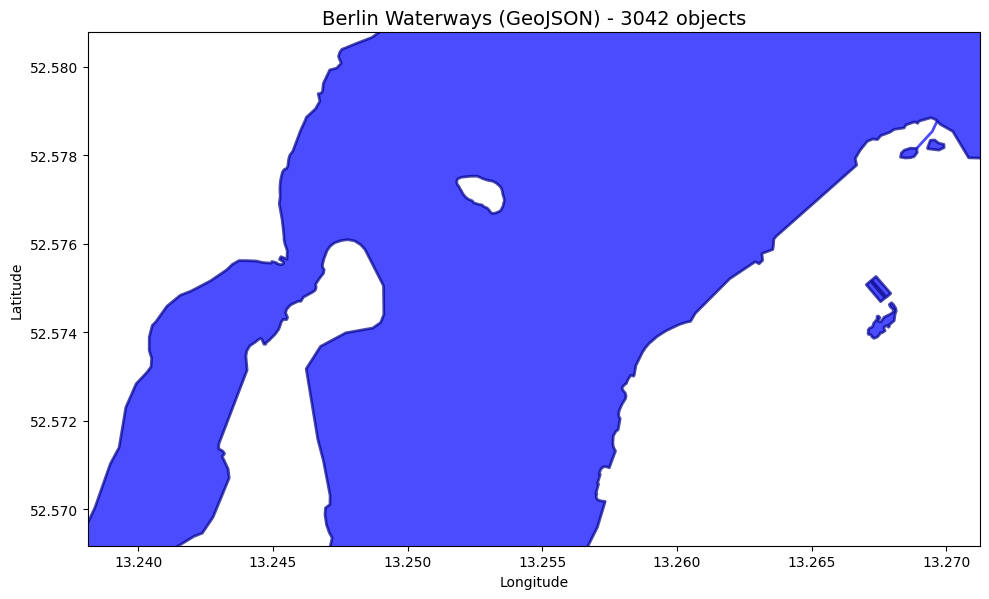

✅ GeoJSON visualization saved as: race_publica_data/geojson_visual_waterways_only.png


/tmp/ipython-input-3211000468.py:96: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


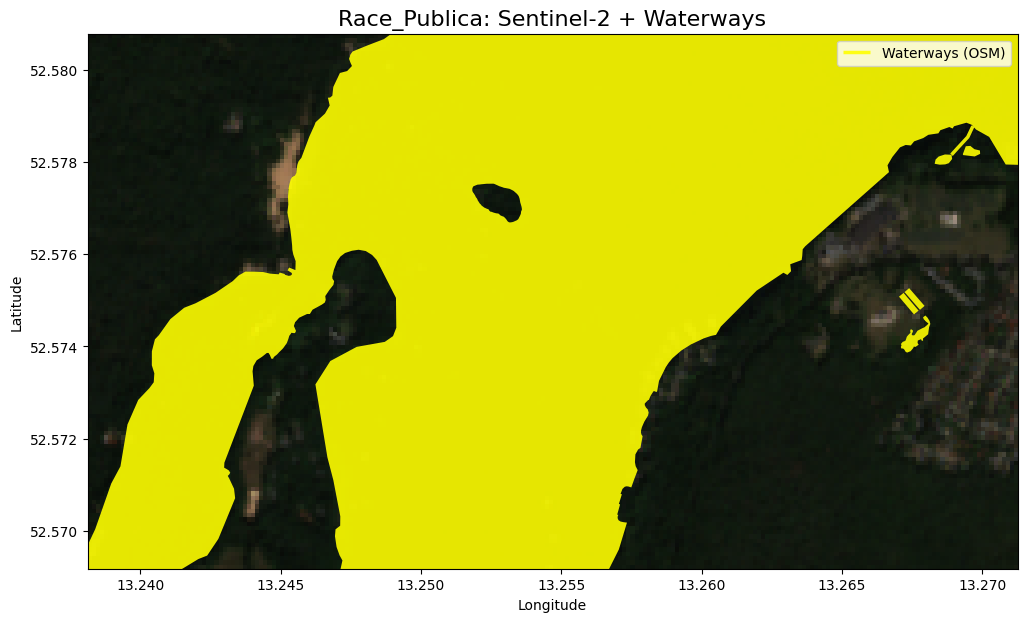

✅ Final overlay visualization saved.

--- 6. Завантаження NDWI Bands (B03, B08) ---
✅ NDWI Bands obtained with shape: (124, 228, 2)
✅ Raster data saved as: race_publica_data/s2_ndwi_bands_berlin.tif

--- 7. Розрахунок NDWI Скорингу та Аналіз Чутливості ---
✅ NDWI map calculated. Size: (124, 228)

📊 Mean NDWI value for waterways: 0.2488
🔴 Predominantly low scoring zone: Водні шляхи можуть мати високу каламутність.


<Figure size 640x480 with 0 Axes>

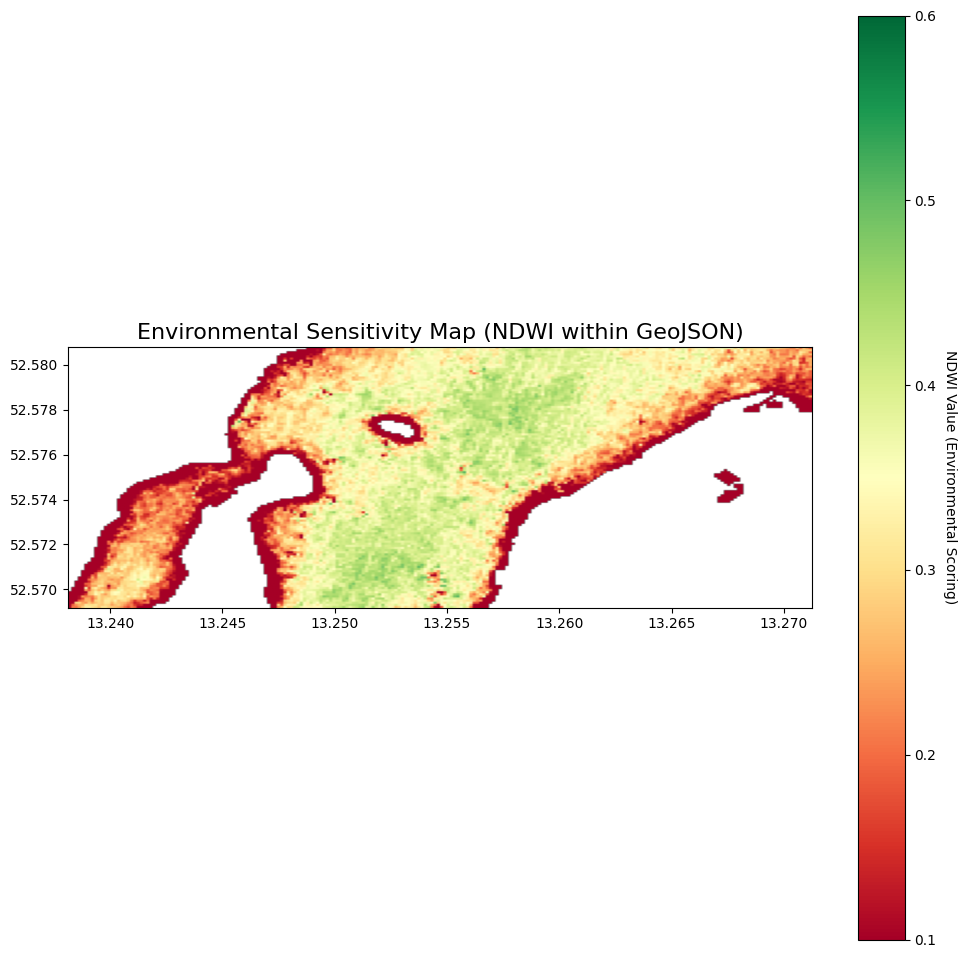

✅ Sensitivity map saved as: race_publica_data/sensitivity_map_ndwi.png


In [ ]:
# --- 0. НАЛАШТУВАННЯ СЕРЕДОВИЩА ТА ІМПОРТИ ---
# Увага: Запуск pip install на початку
!pip install sentinelhub matplotlib pandas numpy geopandas osmnx rasterio scipy --quiet

import matplotlib.pyplot as plt
import numpy as np
import getpass
import geopandas as gpd
import osmnx as ox
import rasterio
from rasterio.transform import from_bounds
from rasterio.features import rasterize
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubRequest,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
)
import os
import pandas as pd
from scipy.interpolate import RegularGridInterpolator # Для інтерполяції скорингу

# --- 1. КОНСТАНТИ ТА НАЛАШТУВАННЯ ПРОЄКТУ ---

OUTPUT_DIR = "race_publica_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"--- 1. Конфігурація Проєкту ---")
print(f"✅ Created working directory: {OUTPUT_DIR}")

# AOI (Берлін): [West, South, East, North]
aoi_coords_wgs84 = [13.23812, 52.56918, 13.27125, 52.58078]
time_interval = ("2024-08-01", "2024-09-30")
resolution = 10 # метрів на піксель
GEOJSON_FILENAME = "berlin_waterways.geojson"
GRAPH_FILE = os.path.join(OUTPUT_DIR, "berlin_walk_network.graphml")

aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

# --- 2. ДОПОМІЖНІ ФУНКЦІЇ ---

def plot_image(image, factor=1.0, clip_range=None, title="True Color Image"):
    """Функція для відображення растрових зображень."""
    fig, ax = plt.subplots(figsize=(10, 10))
    if clip_range:
        ax.imshow(np.clip(image * factor, *clip_range))
    else:
        ax.imshow(image * factor)
    ax.set_title(title, fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

def save_raster_data(image, aoi_coords, aoi_size, filename):
    """Зберігає масив NumPy як GeoTIFF."""
    lon_min, lat_min, lon_max, lat_max = aoi_coords
    width, height = aoi_size
    transform = from_bounds(lon_min, lat_min, lon_max, lat_max, width, height)
    with rasterio.open(
        os.path.join(OUTPUT_DIR, filename),
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=image.shape[2] if image.ndim == 3 else 1,
        dtype=image.dtype,
        crs=CRS.WGS84.ogc_string(),
        transform=transform,
    ) as dst:
        if image.ndim == 3:
            for i in range(image.shape[2]):
                dst.write(image[:, :, i], i + 1)
        else:
            dst.write(image, 1)
    print(f"✅ Raster data saved as: {OUTPUT_DIR}/{filename}")
    return transform # Повертаємо transform для подальшого використання

def plot_overlay(raster_image, vector_gdf, factor=2.5, clip_range=(0, 1), aoi_extent=aoi_coords_wgs84, title="Race_Publica: Sentinel-2 + Waterways"):
    """Відображає растрове зображення з накладанням векторних даних."""
    fig, ax = plt.subplots(figsize=(12, 12))
    extent = [aoi_extent[0], aoi_extent[2], aoi_extent[1], aoi_extent[3]]
    raster_display = np.clip(raster_image * factor, *clip_range)
    ax.imshow(raster_display, extent=extent, origin='upper')

    if not vector_gdf.empty:
        vector_gdf.plot(ax=ax, color='yellow', linewidth=2.5, alpha=0.9, label='Waterways (OSM)')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(aoi_extent[0], aoi_extent[2])
    ax.set_ylim(aoi_extent[1], aoi_extent[3])
    plt.legend()
    plt.show()
    plt.savefig(os.path.join(OUTPUT_DIR, "overlay_visual.png"))
    print(f"✅ Final overlay visualization saved.")

def plot_geojson_only(vector_gdf, aoi_extent=aoi_coords_wgs84, title="Berlin Waterways (GeoJSON)"):
    """Відображає лише векторні дані."""
    fig, ax = plt.subplots(figsize=(10, 10))
    if not vector_gdf.empty:
        vector_gdf.plot(ax=ax, color='blue', linewidth=2, edgecolor='darkblue', alpha=0.7)

    ax.set_title(f"{title} - {len(vector_gdf)} objects", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim(aoi_extent[0], aoi_extent[2])
    ax.set_ylim(aoi_extent[1], aoi_extent[3])
    plt.tight_layout()
    visual_path = os.path.join(OUTPUT_DIR, "geojson_visual_waterways_only.png")
    plt.savefig(visual_path)
    plt.show()
    print(f"✅ GeoJSON visualization saved as: {visual_path}")


# --- 3. НАЛАШТУВАННЯ CREDENTIALS ---

print("\n--- 3. Налаштування Sentinel Hub Credentials ---")
config = SHConfig()

# >>>>>>>>> ВБУДОВАНІ РЕАЛЬНІ ДАНІ ДЛЯ НАЛАГОДЖЕННЯ <<<<<<<<<
config.sh_client_id = "sh-2d66e1f7-ba1d-4bce-88bc-b7baffe1378f"
config.sh_client_secret = "UYNkQKoAe0Z3abO4dOTPZuv6FPF1gphd"
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"

if config.sh_client_id and config.sh_client_secret:
    print("✅ Sentinel Hub configuration for CDSE successfully set.")
else:
    raise SystemExit("❌ КРИТИЧНА ПОМИЛКА: Облікові дані відсутні.")

# --- 4. ЗАВАНТАЖЕННЯ TRUE COLOR (RGB) ТА ВІЗУАЛІЗАЦІЯ ---

print("\n--- 4. Завантаження True Color (RGB) ---")
evalscript_float_color = """
    //VERSION=3
    function setup() {
        return {
            input: [{ bands: ["B02", "B03", "B04"], units: "REFLECTANCE" }],
            output: { bands: 3, sampleType: "FLOAT32" }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""
request_true_color = SentinelHubRequest(
    evalscript=evalscript_float_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(name="s2l2a", service_url=config.sh_base_url),
            time_interval=time_interval,
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox, size=aoi_size, config=config,
)
true_color_imgs = request_true_color.get_data()
if not true_color_imgs:
    raise SystemExit("❌ Помилка: Не вдалося завантажити зображення RGB.")
image = true_color_imgs[0]
print(f"✅ True Color Image obtained with shape: {image.shape}")

# Saving True Color GeoTIFF
save_raster_data(image, aoi_coords_wgs84, aoi_size, "s2_rgb_berlin.tif")

# Visualization
plot_image(image, factor=2.5, clip_range=(0, 1), title="True Color Image (Scaled FLOAT32)")
plt.savefig(os.path.join(OUTPUT_DIR, "s2_rgb_visual.png"))
print(f"✅ Visualization saved as: {OUTPUT_DIR}/s2_rgb_visual.png")


# --- 5. ЗАВАНТАЖЕННЯ ВЕКТОРНИХ ДАНИХ (OSM/GeoJSON) ---

print("\n--- 5. Завантаження GeoJSON Водних Шляхів (OSM) ---")
place_name = "Berlin, Germany"
tags_lines = {'waterway': ['river', 'canal', 'stream', 'drain']}
tags_poly = {'natural': 'water'}

try:
    print(f"⏳ Downloading waterway data for {place_name}...")
    gdf_lines = ox.features_from_place(place_name, tags_lines)
    gdf_poly = ox.features_from_place(place_name, tags_poly)

    gdf_lines = gdf_lines[gdf_lines.geometry.geom_type.isin(['LineString', 'MultiLineString'])][['geometry']]
    gdf_poly = gdf_poly[gdf_poly.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])][['geometry']]

    gdf_waterways = pd.concat([gdf_lines.geometry, gdf_poly.geometry], ignore_index=True)
    gdf_waterways = gpd.GeoDataFrame(geometry=gdf_waterways, crs=CRS.WGS84.ogc_string())

    geojson_filepath = os.path.join(OUTPUT_DIR, GEOJSON_FILENAME)
    gdf_waterways.to_file(geojson_filepath, driver='GeoJSON')
    print(f"✅ Векторні дані збережено. Об'єктів: {len(gdf_waterways)}")

except Exception as e:
    print(f"❌ Помилка при завантаженні GeoJSON: {e}")
    gdf_waterways = gpd.GeoDataFrame()
    raise SystemExit("Критична помилка: Не вдалося завантажити водні шляхи OSM.")

# --- 5.1. Візуалізація Векторних Даних ---
if not gdf_waterways.empty:
    # 1. Окрема візуалізація GeoJSON (як просили)
    plot_geojson_only(gdf_waterways, aoi_extent=aoi_coords_wgs84)

    # 2. Візуалізація накладання RGB та GeoJSON (для контексту)
    with rasterio.open(os.path.join(OUTPUT_DIR, "s2_rgb_berlin.tif")) as src:
        raster_loaded = src.read()
        image_loaded = np.transpose(raster_loaded, (1, 2, 0))
    plot_overlay(image_loaded, gdf_waterways, aoi_extent=aoi_coords_wgs84)


# --- 6. ЗАВАНТАЖЕННЯ NDWI BANDS (B03, B08) ---

print("\n--- 6. Завантаження NDWI Bands (B03, B08) ---")
evalscript_ndwi_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{ bands: ["B03", "B08"], units: "REFLECTANCE" }],
            output: { bands: 2, sampleType: "FLOAT32" }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B03, sample.B08];
    }
"""
request_ndwi_bands = SentinelHubRequest(
    evalscript=evalscript_ndwi_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(name="s2l2a", service_url=config.sh_base_url),
            time_interval=time_interval,
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox, size=aoi_size, config=config,
)
ndwi_bands_imgs = request_ndwi_bands.get_data()
if not ndwi_bands_imgs:
    raise SystemExit("❌ Помилка: Не вдалося завантажити NDWI Bands.")
ndwi_image_3d = ndwi_bands_imgs[0]
print(f"✅ NDWI Bands obtained with shape: {ndwi_image_3d.shape}")

# Saving the NDWI bands GeoTIFF
RASTER_NDWI_BANDS_PATH = os.path.join(OUTPUT_DIR, "s2_ndwi_bands_berlin.tif")
transform = save_raster_data(ndwi_image_3d, aoi_coords_wgs84, aoi_size, "s2_ndwi_bands_berlin.tif")


# --- 7. РОЗРАХУНОК NDWI СКОРИНГУ ТА АНАЛІЗ ЧУТЛИВОСТІ ---

print("\n--- 7. Розрахунок NDWI Скорингу та Аналіз Чутливості ---")
B03 = ndwi_image_3d[:, :, 0].astype('float32')
B08 = ndwi_image_3d[:, :, 1].astype('float32')

# 7.1. NDWI Calculation
with np.errstate(divide='ignore', invalid='ignore'):
    ndwi_map = (B03 - B08) / (B03 + B08)
ndwi_map[np.isnan(ndwi_map)] = 0
ndwi_map[np.isinf(ndwi_map)] = 0
print(f"✅ NDWI map calculated. Size: {ndwi_map.shape}")

# 7.2. GeoJSON Rasterization and NDWI Clipping
shapes_with_values = [(geom, 1) for geom in gdf_waterways.geometry]

water_mask = rasterize(
    shapes=shapes_with_values,
    out_shape=ndwi_map.shape,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype=np.uint8
)
ndwi_water_only = np.where(water_mask == 1, ndwi_map, np.nan)

# 7.3. Final Scoring Analysis
ndwi_water_values = ndwi_water_only[~np.isnan(ndwi_water_only)] # Фільтруємо NaN

if ndwi_water_values.size > 0:
    mean_ndwi = np.nanmean(ndwi_water_values)
    print(f"\n📊 Mean NDWI value for waterways: {mean_ndwi:.4f}")
    if mean_ndwi < 0.25:
        print("🔴 Predominantly low scoring zone: Водні шляхи можуть мати високу каламутність.")
    elif mean_ndwi > 0.40:
        print("🟢 Predominantly high scoring zone: Вода чиста, маршрути бажані.")
    else:
        print("🟡 Medium scoring zone.")
else:
    print("⚠️ GeoJSON overlay on NDWI did not find valid water pixels.")

# 7.4. Scoring Visualization
fig, ax = plt.subplots(figsize=(12, 12))
extent = [aoi_coords_wgs84[0], aoi_coords_wgs84[2], aoi_coords_wgs84[1], aoi_coords_wgs84[3]]
im = ax.imshow(
    ndwi_water_only, extent=extent, cmap='RdYlGn', vmin=0.1, vmax=0.6, origin='upper'
)
ax.set_title("Environmental Sensitivity Map (NDWI within GeoJSON)", fontsize=16)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('NDWI Value (Environmental Scoring)', rotation=270, labelpad=15)
visual_path_sensitivity = os.path.join(OUTPUT_DIR, "sensitivity_map_ndwi.png")
plt.savefig(visual_path_sensitivity)
plt.show()
print(f"✅ Sensitivity map saved as: {visual_path_sensitivity}")




--- 1. Конфігурація Проєкту ---
✅ Created working directory: race_publica_data

--- 3. Налаштування Sentinel Hub Credentials ---
✅ Sentinel Hub configuration for CDSE successfully set.

--- 4. Завантаження True Color (RGB) ---
✅ True Color Image obtained with shape: (124, 228, 3)
✅ Raster data saved as: race_publica_data/s2_rgb_berlin.tif


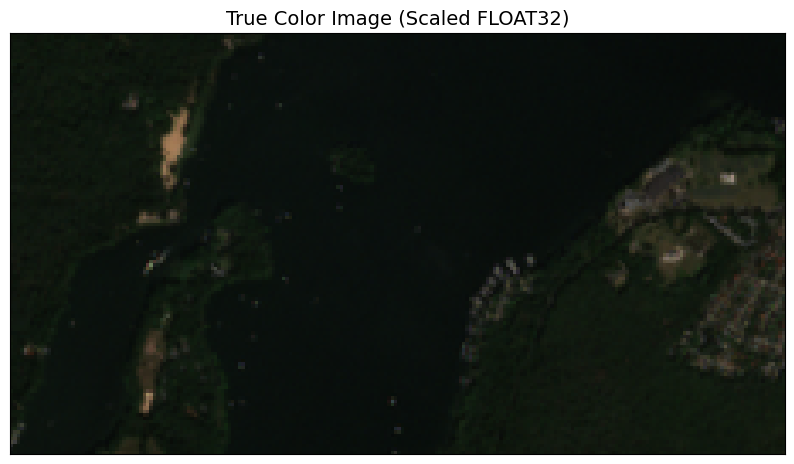

✅ Visualization saved as: race_publica_data/s2_rgb_visual.png

--- 5. Завантаження GeoJSON Водних Шляхів (OSM) ---
⏳ Downloading waterway data using ox.features_from_polygon...
✅ Векторні дані збережено. Об'єктів: 7
✅ GeoJSON visualization saved as: race_publica_data/geojson_visual_waterways_only.png


<Figure size 640x480 with 0 Axes>

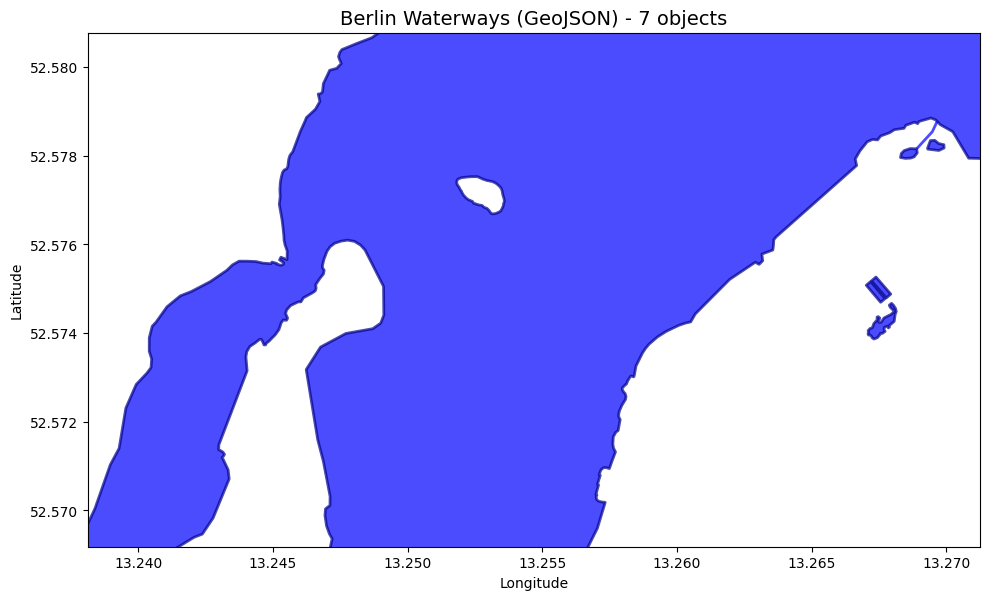

/tmp/ipython-input-294276260.py:98: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


✅ Final overlay visualization saved.


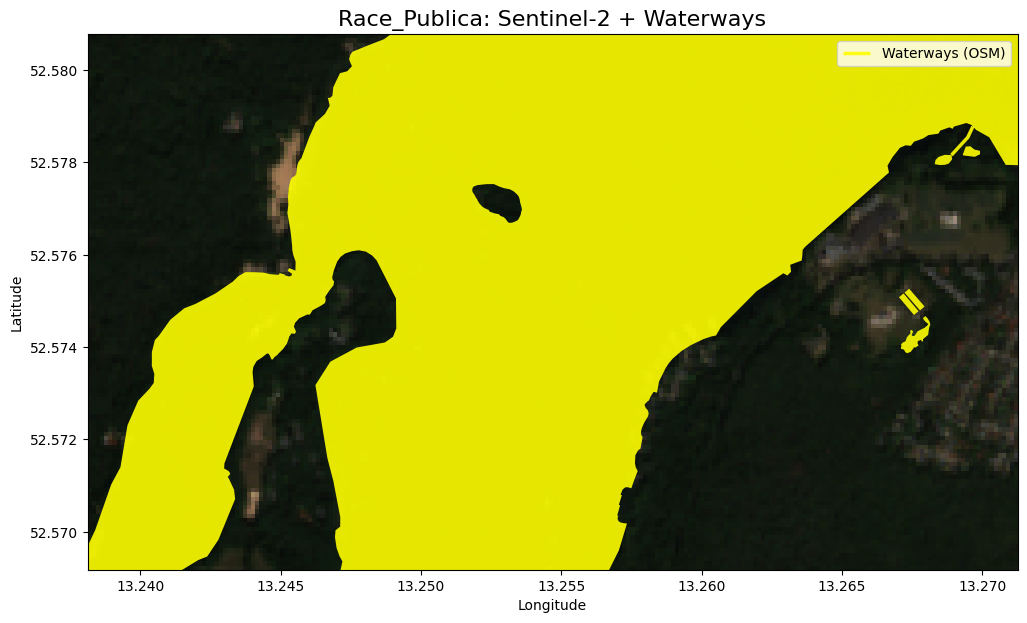


--- 6. Завантаження NDWI Bands (B03, B08) ---
✅ NDWI Bands obtained with shape: (124, 228, 2)
✅ Raster data saved as: race_publica_data/s2_ndwi_bands_berlin.tif

--- 7. Розрахунок NDWI Скорингу та Аналіз Чутливості ---
✅ Sensitivity map saved as: race_publica_data/sensitivity_map_ndwi.png


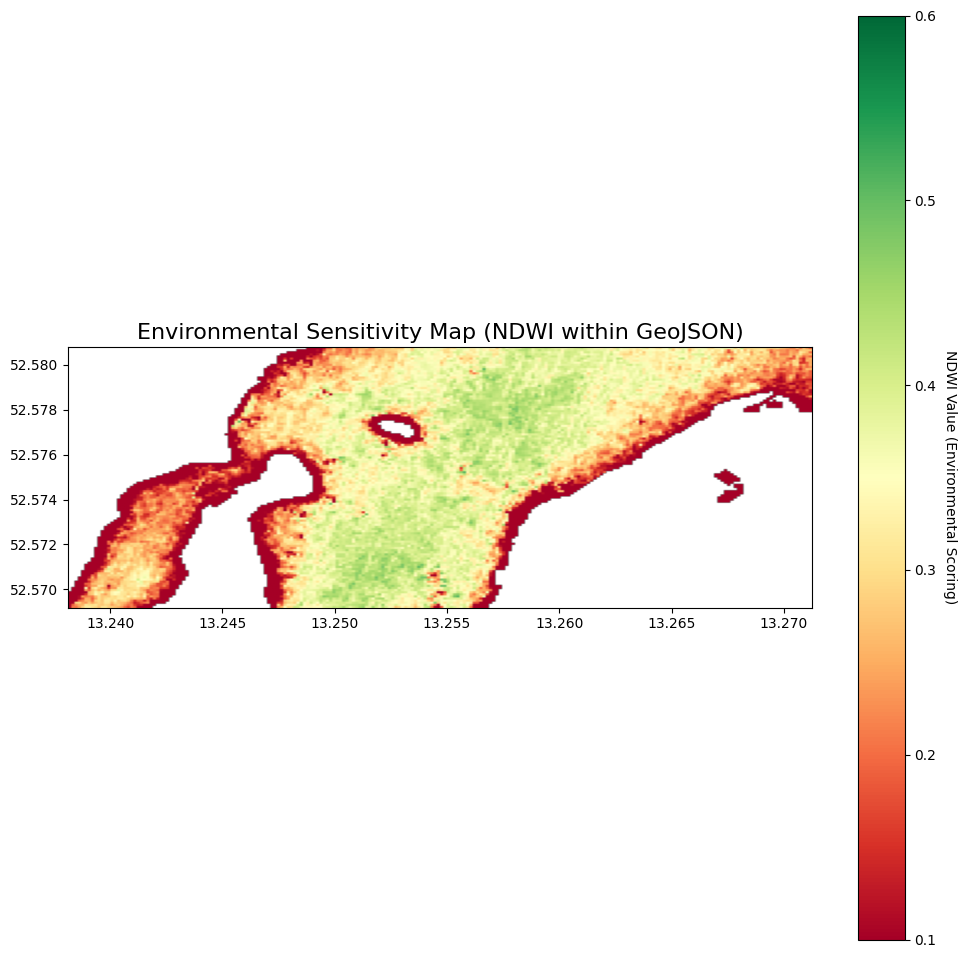


--- 8. Створення GeoJSON з Пікселями NDWI ---
✅ GeoJSON з NDWI пікселями збережено: race_publica_data/ndwi_pixels_water.geojson
   Кількість точок: 15923


In [ ]:
# --- 0. НАЛАШТУВАННЯ СЕРЕДОВИЩА ТА ІМПОРТИ ---
# Увага: Запуск pip install на початку
!pip install sentinelhub matplotlib pandas numpy geopandas osmnx rasterio scipy shapely --quiet

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import osmnx as ox
import rasterio
from rasterio.transform import from_bounds
from rasterio.features import rasterize
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubRequest,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
)
import os
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
from rasterio.transform import Affine
from shapely.geometry import Polygon

# --- 1. КОНСТАНТИ ТА НАЛАШТУВАННЯ ПРОЄКТУ ---

OUTPUT_DIR = "race_publica_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"--- 1. Конфігурація Проєкту ---")
print(f"✅ Created working directory: {OUTPUT_DIR}")

# AOI (Берлін): [West, South, East, North]
aoi_coords_wgs84 = [13.23812, 52.56918, 13.27125, 52.58078]
time_interval = ("2024-08-01", "2024-09-30")
resolution = 10 # метрів на піксель
GEOJSON_FILENAME = "berlin_waterways.geojson"

aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

# --- 2. ДОПОМІЖНІ ФУНКЦІЇ ---

def plot_image(image, factor=1.0, clip_range=None, title="True Color Image"):
    """Функція для відображення растрових зображень."""
    fig, ax = plt.subplots(figsize=(10, 10))
    if clip_range:
        ax.imshow(np.clip(image * factor, *clip_range))
    else:
        ax.imshow(image * factor)
    ax.set_title(title, fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

def save_raster_data(image, aoi_coords, aoi_size, filename):
    """Зберігає масив NumPy як GeoTIFF."""
    lon_min, lat_min, lon_max, lat_max = aoi_coords
    width, height = aoi_size
    transform = from_bounds(lon_min, lat_min, lon_max, lat_max, width, height)
    count_val = image.shape[2] if image.ndim == 3 else 1

    with rasterio.open(
        os.path.join(OUTPUT_DIR, filename),
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=count_val,
        dtype=image.dtype,
        crs=CRS.WGS84.ogc_string(),
        transform=transform,
    ) as dst:
        if image.ndim == 3:
            for i in range(image.shape[2]):
                dst.write(image[:, :, i], i + 1)
        else:
            dst.write(image, 1)
    print(f"✅ Raster data saved as: {OUTPUT_DIR}/{filename}")
    return transform

def plot_overlay(raster_image, vector_gdf, factor=2.5, clip_range=(0, 1), aoi_extent=aoi_coords_wgs84, title="Race_Publica: Sentinel-2 + Waterways"):
    """Відображає растрове зображення з накладанням векторних даних."""
    fig, ax = plt.subplots(figsize=(12, 12))
    extent = [aoi_extent[0], aoi_extent[2], aoi_extent[1], aoi_extent[3]]
    raster_display = np.clip(raster_image * factor, *clip_range)
    ax.imshow(raster_display, extent=extent, origin='upper')

    if not vector_gdf.empty:
        vector_gdf.plot(ax=ax, color='yellow', linewidth=2.5, alpha=0.9, label='Waterways (OSM)')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(aoi_extent[0], aoi_extent[2])
    ax.set_ylim(aoi_extent[1], aoi_extent[3])
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_DIR, "overlay_visual.png"))
    print(f"✅ Final overlay visualization saved.")
    plt.show()

def plot_geojson_only(vector_gdf, aoi_extent=aoi_coords_wgs84, title="Berlin Waterways (GeoJSON)"):
    """Відображає лише векторні дані."""
    fig, ax = plt.subplots(figsize=(10, 10))
    if not vector_gdf.empty:
        vector_gdf.plot(ax=ax, color='blue', linewidth=2, edgecolor='darkblue', alpha=0.7)

    ax.set_title(f"{title} - {len(vector_gdf)} objects", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim(aoi_extent[0], aoi_extent[2])
    ax.set_ylim(aoi_extent[1], aoi_extent[3])
    plt.tight_layout()
    visual_path = os.path.join(OUTPUT_DIR, "geojson_visual_waterways_only.png")
    plt.savefig(visual_path)
    print(f"✅ GeoJSON visualization saved as: {visual_path}")
    plt.show()


# --- 3. НАЛАШТУВАННЯ CREDENTIALS ---

print("\n--- 3. Налаштування Sentinel Hub Credentials ---")
config = SHConfig()

# >>>>>>>>> ВБУДОВАНІ РЕАЛЬНІ ДАНІ ДЛЯ НАЛАГОДЖЕННЯ <<<<<<<<<
config.sh_client_id = "sh-2d66e1f7-ba1d-4bce-88bc-b7baffe1378f"
config.sh_client_secret = "UYNkQKoAe0Z3abO4dOTPZuv6FPF1gphd"
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"

if config.sh_client_id and config.sh_client_secret:
    print("✅ Sentinel Hub configuration for CDSE successfully set.")
else:
    raise SystemExit("❌ КРИТИЧНА ПОМИЛКА: Облікові дані відсутні.")

# --- 4. ЗАВАНТАЖЕННЯ TRUE COLOR (RGB) ТА ВІЗУАЛІЗАЦІЯ ---

print("\n--- 4. Завантаження True Color (RGB) ---")
evalscript_float_color = """
    //VERSION=3
    function setup() {
        return {
            input: [{ bands: ["B02", "B03", "B04"], units: "REFLECTANCE" }],
            output: { bands: 3, sampleType: "FLOAT32" }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""
request_true_color = SentinelHubRequest(
    evalscript=evalscript_float_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(name="s2l2a", service_url=config.sh_base_url),
            time_interval=time_interval,
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox, size=aoi_size, config=config,
)
try:
    true_color_imgs = request_true_color.get_data()
    if not true_color_imgs:
        raise Exception("Не вдалося завантажити зображення RGB.")
    image = true_color_imgs[0]
    print(f"✅ True Color Image obtained with shape: {image.shape}")

    # ВИПРАВЛЕННЯ: Змінено ai_size на aoi_size
    save_raster_data(image, aoi_coords_wgs84, aoi_size, "s2_rgb_berlin.tif")

    plot_image(image, factor=2.5, clip_range=(0, 1), title="True Color Image (Scaled FLOAT32)")
    plt.savefig(os.path.join(OUTPUT_DIR, "s2_rgb_visual.png"))
    print(f"✅ Visualization saved as: {OUTPUT_DIR}/s2_rgb_visual.png")
except Exception as e:
    # Залишаємо виведення помилки для налагодження, якщо вона виникне тут
    print(f"❌ Помилка завантаження RGB: {e}")
    image = np.zeros((aoi_size[1], aoi_size[0], 3), dtype=np.float32)
    print("❌ Використовується заглушка RGB.")


# --- 5. ЗАВАНТАЖЕННЯ ВЕКТОРНИХ ДАНИХ (OSM/GeoJSON) - ВИПРАВЛЕНО ---

print("\n--- 5. Завантаження GeoJSON Водних Шляхів (OSM) ---")
tags_lines = {'waterway': ['river', 'canal', 'stream', 'drain']}
tags_poly = {'natural': 'water'}
geojson_filepath = os.path.join(OUTPUT_DIR, GEOJSON_FILENAME)

# AOI: [West, South, East, North]
W, S, E, N = aoi_coords_wgs84

try:
    print("⏳ Downloading waterway data using ox.features_from_polygon...")

    # Створення об'єкта Shapely Polygon з координат BBox
    polygon_geom = Polygon([
        (W, S), (W, N), (E, N), (E, S), (W, S)
    ])

    # 1. Завантаження лінійних об'єктів
    gdf_lines = ox.features_from_polygon(polygon_geom, tags_lines)
    # 2. Завантаження полігональних об'єктів
    gdf_poly = ox.features_from_polygon(polygon_geom, tags_poly)

    # 3. Фільтрація та об'єднання
    gdf_lines = gdf_lines[gdf_lines.geometry.geom_type.isin(['LineString', 'MultiLineString'])][['geometry']]
    gdf_poly = gdf_poly[gdf_poly.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])][['geometry']]

    gdf_waterways = pd.concat([gdf_lines.geometry, gdf_poly.geometry], ignore_index=True)
    gdf_waterways = gpd.GeoDataFrame(geometry=gdf_waterways, crs=CRS.WGS84.ogc_string())


    if len(gdf_waterways) == 0:
        print("⚠️ УВАГА: Завантажено 0 об'єктів OSM.")
    else:
        gdf_waterways.to_file(geojson_filepath, driver='GeoJSON')
        print(f"✅ Векторні дані збережено. Об'єктів: {len(gdf_waterways)}")

except Exception as e:
    print(f"❌ КРИТИЧНА ПОМИЛКА при завантаженні GeoJSON: {e}")
    # *** ЗАГЛУШКА ***
    gdf_waterways = gpd.GeoDataFrame(geometry=[], crs=CRS.WGS84.ogc_string())
    print("❌ Створено порожній GeoDataFrame водних шляхів.")


# --- 5.1. Візуалізація Векторних Даних ---
if not gdf_waterways.empty:
    plot_geojson_only(gdf_waterways, aoi_extent=aoi_coords_wgs84)

    try:
        with rasterio.open(os.path.join(OUTPUT_DIR, "s2_rgb_berlin.tif")) as src:
            raster_loaded = src.read()
            image_loaded = np.transpose(raster_loaded, (1, 2, 0))
        plot_overlay(image_loaded, gdf_waterways, aoi_extent=aoi_coords_wgs84)
    except Exception as e:
        print(f"❌ Не вдалося візуалізувати накладання GeoJSON на RGB: {e}")


# --- 6. ЗАВАНТАЖЕННЯ NDWI BANDS (B03, B08) ---

print("\n--- 6. Завантаження NDWI Bands (B03, B08) ---")
evalscript_ndwi_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{ bands: ["B03", "B08"], units: "REFLECTANCE" }],
            output: { bands: 2, sampleType: "FLOAT32" }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B03, sample.B08];
    }
"""
request_ndwi_bands = SentinelHubRequest(
    evalscript=evalscript_ndwi_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(name="s2l2a", service_url=config.sh_base_url),
            time_interval=time_interval,
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox, size=aoi_size, config=config,
)

try:
    ndwi_bands_imgs = request_ndwi_bands.get_data()
    if not ndwi_bands_imgs:
        raise Exception("Не вдалося завантажити NDWI Bands.")
    ndwi_image_3d = ndwi_bands_imgs[0]
    print(f"✅ NDWI Bands obtained with shape: {ndwi_image_3d.shape}")

    RASTER_NDWI_BANDS_PATH = os.path.join(OUTPUT_DIR, "s2_ndwi_bands_berlin.tif")
    transform = save_raster_data(ndwi_image_3d, aoi_coords_wgs84, aoi_size, "s2_ndwi_bands_berlin.tif")

except Exception as e:
    print(f"❌ Помилка завантаження NDWI Bands: {e}")
    ndwi_image_3d = np.zeros((aoi_size[1], aoi_size[0], 2), dtype=np.float32)
    lon_min, lat_min, lon_max, lat_max = aoi_coords_wgs84
    width, height = aoi_size
    transform = Affine(
        (lon_max - lon_min) / width, 0.0, lon_min,
        0.0, -(lat_max - lat_min) / height, lat_max
    )
    print("❌ Використовується заглушка NDWI Bands.")


# --- 7. РОЗРАХУНОК NDWI СКОРИНГУ ТА АНАЛІЗ ЧУТЛИВОСТІ ---

print("\n--- 7. Розрахунок NDWI Скорингу та Аналіз Чутливості ---")
B03 = ndwi_image_3d[:, :, 0].astype('float32')
B08 = ndwi_image_3d[:, :, 1].astype('float32')

# 7.1. NDWI Calculation
with np.errstate(divide='ignore', invalid='ignore'):
    ndwi_map = (B03 - B08) / (B03 + B08)
ndwi_map[np.isnan(ndwi_map)] = 0
ndwi_map[np.isinf(ndwi_map)] = 0
ndwi_water_only = ndwi_map.copy()

if not gdf_waterways.empty:
    # 7.2. GeoJSON Rasterization and NDWI Clipping
    shapes_with_values = [(geom, 1) for geom in gdf_waterways.geometry]

    water_mask = rasterize(
        shapes=shapes_with_values,
        out_shape=ndwi_map.shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype=np.uint8
    )
    ndwi_water_only = np.where(water_mask == 1, ndwi_map, np.nan)


# 7.3. Scoring Visualization
fig, ax = plt.subplots(figsize=(12, 12))
extent = [aoi_coords_wgs84[0], aoi_coords_wgs84[2], aoi_coords_wgs84[1], aoi_coords_wgs84[3]]
im = ax.imshow(
    ndwi_water_only, extent=extent, cmap='RdYlGn', vmin=0.1, vmax=0.6, origin='upper'
)
ax.set_title("Environmental Sensitivity Map (NDWI within GeoJSON)", fontsize=16)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('NDWI Value (Environmental Scoring)', rotation=270, labelpad=15)
visual_path_sensitivity = os.path.join(OUTPUT_DIR, "sensitivity_map_ndwi.png")
plt.savefig(visual_path_sensitivity)
print(f"✅ Sensitivity map saved as: {visual_path_sensitivity}")
plt.show()


# --- 8. СТВОРЕННЯ GEOJSON З ПІКСЕЛЯМИ NDWI ---

print("\n--- 8. Створення GeoJSON з Пікселями NDWI ---")
if not gdf_waterways.empty:
    valid_ndwi_mask = ~np.isnan(ndwi_water_only)
    ndwi_values = ndwi_water_only[valid_ndwi_mask]

    rows_indices, cols_indices = np.where(valid_ndwi_mask)

    if ndwi_values.size > 0:
        # Перетворення піксельних індексів у географічні координати (WGS84)
        longitudes, latitudes = rasterio.transform.xy(transform, rows_indices, cols_indices, offset='center')

        # Створення GeoDataFrame
        ndwi_points_gdf = gpd.GeoDataFrame(
            data={'NDWI': ndwi_values},
            geometry=gpd.points_from_xy(longitudes, latitudes),
            crs=CRS.WGS84.ogc_string()
        )

        # Збереження GeoJSON
        geojson_ndwi_path = os.path.join(OUTPUT_DIR, "ndwi_pixels_water.geojson")
        ndwi_points_gdf.to_file(geojson_ndwi_path, driver='GeoJSON')
        print(f"✅ GeoJSON з NDWI пікселями збережено: {geojson_ndwi_path}")
        print(f"   Кількість точок: {len(ndwi_points_gdf)}")
    else:
        print("❌ Не знайдено дійсних NDWI-значень на водних шляхах для експорту.")
else:
    print("❌ Не завантажено векторні дані водних шляхів. GeoJSON NDWI не створюється.")

In [ ]:
!pip install folium

In [ ]:
%pip install folium>=0.12 matplotlib mapclassify

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString
from ipyleaflet import Map, basemaps, GeoJSON
from IPython.display import display
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np
import os
import time
import pickle # Додано для надійного кешування

# --- КОНФІГУРАЦІЯ ФАЙЛІВ ТА ПАРАМЕТРИ ---
GEOJSON_FILE = '/content/race_publica_data/ndwi_pixels_water.geojson'
GRAPH_FILE = 'optimized_water_graph.gpickle' # Кеш формат

# Параметри графа та прискорення
R = 0.000005           # 💡 ЗМЕНШЕНО РАДІУС для запобігання стрибків через суходіл (було 0.005)
SUBSAMPLE_STEP = 5  # Крок вибірки (було 2)

# Параметр взаємодії
CLICK_RADIUS = 0.001
# ------------------------------------------

# --- 1. Завантаження та підготовка даних ---
print("⏳ ЕТАП 1: Завантаження GeoJSON та застосування вибірки...")
start_time_1 = time.time()

try:
    gdf_all = gpd.read_file(GEOJSON_FILE)

    # Застосування вибірки
    if SUBSAMPLE_STEP > 1:
        gdf_vessels = gdf_all.iloc[::SUBSAMPLE_STEP, :].copy().reset_index(drop=True)
        print(f"    ➡️ Застосовано вибірку (кожна {SUBSAMPLE_STEP}-та точка).")
        print(f"    Точок: {len(gdf_all)} -> {len(gdf_vessels)} ({len(gdf_vessels)/len(gdf_all)*100:.1f}% від оригіналу).")
    else:
        gdf_vessels = gdf_all
        print(f"    ➡️ Використовуються всі точки: {len(gdf_vessels)}.")

    gdf_vessels['node_id'] = range(len(gdf_vessels))

except FileNotFoundError:
    print(f"Помилка: Файл {GEOJSON_FILE} не знайдено. Створення тестових даних.")
    data = {'NDWI': [0.1, -0.2, 0.5, -0.4, 0.7, 0.9, 0.1],
            'geometry': [Point(30.5, 50.4), Point(30.6, 50.5), Point(30.4, 50.3), Point(30.7, 50.6),
                         Point(30.55, 50.45), Point(30.65, 50.55), Point(30.45, 50.35)]}
    gdf_vessels = gpd.GeoDataFrame(data, crs="EPSG:4326")
    gdf_vessels['node_id'] = range(len(gdf_vessels))

end_time_1 = time.time()
print(f"⏱️ ЕТАП 1 завершено за: {end_time_1 - start_time_1:.2f} сек.")

# Обчислення центру мапи
center_lat = gdf_vessels.geometry.y.mean()
center_lon = gdf_vessels.geometry.x.mean()


# --- 2. Створення / Завантаження ОПТИМІЗОВАНОГО Графа (КЕШУВАННЯ) ---
print("\n⏳ ЕТАП 2: Перевірка та побудова/завантаження графа...")
start_time_2 = time.time()

G = None
should_build_new_graph = True

if os.path.exists(GRAPH_FILE) and os.path.exists(GEOJSON_FILE):
    geojson_mtime = os.path.getmtime(GEOJSON_FILE)
    graph_mtime = os.path.getmtime(GRAPH_FILE)

    # Перевірка актуальності кешу
    if graph_mtime > geojson_mtime:
        print(f"    ➡️ Кеш ({time.ctime(graph_mtime)}) новіший за GeoJSON. Швидке завантаження...")
        try:
            # 💡 ВИПРАВЛЕННЯ: Використовуємо стандартний pickle
            with open(GRAPH_FILE, 'rb') as f:
                G = pickle.load(f)
            print(f"    ✅ Граф завантажено: {G.number_of_nodes()} вузлів, {G.number_of_edges()} ребер (R={R}).")
            should_build_new_graph = False
        except Exception as e:
            print(f"    ❌ Помилка при завантаженні графа (файл пошкоджений або недійсний): {e}. Буде створено новий граф.")
            should_build_new_graph = True
    else:
        print(f"    🕒 GeoJSON ({time.ctime(geojson_mtime)}) змінено після створення кешу. Буде створено новий граф.")
elif os.path.exists(GEOJSON_FILE):
     print(f"    ❌ Файл кешу '{GRAPH_FILE}' не знайдено. Створення графа з нуля...")

if G is None and not os.path.exists(GEOJSON_FILE):
     print("    Створення графа на основі тестових даних...")


if should_build_new_graph:
    # >>> ЛОГІКА СТВОРЕННЯ (Повільно, тільки при необхідності) <<<

    coords = np.array(list(zip(gdf_vessels.geometry.x, gdf_vessels.geometry.y)))

    nn = NearestNeighbors(radius=R, algorithm='ball_tree').fit(coords)
    distances_list, indices_list = nn.radius_neighbors(coords)

    G = nx.Graph()

    # Нормалізація NDWI
    min_ndwi_true = gdf_vessels['NDWI'].min()
    gdf_vessels['NDWI_normalized'] = gdf_vessels['NDWI'] - min_ndwi_true
    epsilon = 0.001

    print(f"    ⚙️ Побудова графа з {len(gdf_vessels)} точок. Це може зайняти деякий час...")

    for i in range(len(gdf_vessels)):
        row = gdf_vessels.iloc[i]

        G.add_node(row['node_id'], x=row.geometry.x, y=row.geometry.y, ndwi=row['NDWI'])

        ndwi_cost = 1.0 / (row['NDWI_normalized'] + epsilon)

        neighbors_indices = indices_list[i]
        neighbors_distances = distances_list[i]

        for j in range(len(neighbors_indices)):
            target_index = neighbors_indices[j]
            distance = neighbors_distances[j]

            if i == target_index:
                continue

            target_node_id = gdf_vessels.iloc[target_index]['node_id']

            G.add_edge(
                row['node_id'],
                target_node_id,
                weight_dist=distance,
                weight_ndwi=ndwi_cost * distance
            )

    print(f"    ✅ Граф створено: {G.number_of_nodes()} вузлів, {G.number_of_edges()} ребер.")

    # Зберігаємо граф
    try:
        # 💡 ВИПРАВЛЕННЯ: Використовуємо стандартний pickle
        with open(GRAPH_FILE, 'wb') as f:
            pickle.dump(G, f)
        print(f"    💾 Граф збережено як '{GRAPH_FILE}'.")
    except Exception as e:
        print(f"    ❌ Помилка при збереженні графа: {e}")

end_time_2 = time.time()
print(f"⏱️ ЕТАП 2 завершено за: {end_time_2 - start_time_2:.2f} сек.")


# --- 3. Функції Допомоги та Обробник Кліків ---

clicked_coords = []
m = None

def find_nearest_node(lat, lon):
    """Знаходить найближчий вузол (точку) в gdf_vessels до кліку в межах CLICK_RADIUS."""
    coords_for_nn = np.array(list(zip(gdf_vessels.geometry.y, gdf_vessels.geometry.x)))
    nn_search = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(coords_for_nn)

    distances, indices = nn_search.kneighbors([[lat, lon]])
    nearest_distance = distances[0][0]

    if nearest_distance > CLICK_RADIUS:
        return None

    nearest_index = indices[0][0]
    node_id = gdf_vessels.iloc[nearest_index]['node_id']
    return node_id

def create_path_geojson(path_nodes, start_point, end_point, color):
    """Створює GeoJSON-об'єкт для шляху."""
    path_geometries = [
        gdf_vessels[gdf_vessels['node_id'] == node_id].geometry.iloc[0]
        for node_id in path_nodes
    ]
    final_path_coords = [start_point] + path_geometries + [end_point]
    path_line = LineString([(p.x, p.y) for p in final_path_coords])
    gdf_path = gpd.GeoDataFrame([1], geometry=[path_line], crs=gdf_vessels.crs)

    return GeoJSON(
        data=gdf_path.__geo_interface__,
        style={'color': color, 'weight': 5, 'opacity': 0.8}
    )

def handle_click(**kwargs):
    """Функція, яка викликається при кліку на мапі, для пошуку та відображення двох шляхів."""
    global m
    if kwargs.get('type') == 'click':
        lat, lon = kwargs.get('coordinates')

        if len(clicked_coords) < 2:
            clicked_coords.append((lat, lon))
            print(f"\nКлік {len(clicked_coords)} збережено. ({lat:.4f}, {lon:.4f}).")

            if len(clicked_coords) == 2:
                print("\n⏳ ЕТАП 3: Пошук маршрутів...")
                start_time_3 = time.time()

                start_lat, start_lon = clicked_coords[0]
                end_lat, end_lon = clicked_coords[1]

                start_node_id = find_nearest_node(start_lat, start_lon)
                end_node_id = find_nearest_node(end_lat, end_lon)

                # Перевірка, чи були кліки на воді
                if start_node_id is None or end_node_id is None:
                    print(f"❌ Помилка: Клік зроблено занадто далеко від точок на воді (радіус {CLICK_RADIUS}). Спробуйте клікнути точніше.")
                    clicked_coords.clear()
                    return

                if start_node_id == end_node_id:
                     print("Початкова та кінцева точки знаходяться на одному вузлі.")
                     clicked_coords.clear()
                     return

                # Видаляємо всі попередні шляхи
                layers_to_remove = [layer for layer in m.layers if getattr(layer, 'style', {}).get('color') in ['red', 'green']]
                for layer in layers_to_remove:
                    m.remove_layer(layer)

                start_point = Point(start_lon, start_lat)
                end_point = Point(end_lon, end_lat)

                # --- 4.1. ЧЕРВОНИЙ ШЛЯХ (Відстань) ---
                start_time_red = time.time()
                try:
                    path_dist_nodes = nx.shortest_path(G, source=start_node_id, target=end_node_id, weight='weight_dist')
                    path_dist_geojson = create_path_geojson(path_dist_nodes, start_point, end_point, 'red')
                    m.add_layer(path_dist_geojson)
                    time_red = time.time() - start_time_red
                    print(f"    1. ✅ ЧЕРВОНИЙ (Відстань): Шлях знайдено ({len(path_dist_nodes)} вузлів). Час: {time_red:.4f} сек.")

                except nx.NetworkXNoPath:
                    print("    1. ❌ ЧЕРВОНИЙ: Шлях за відстанню не знайдено.")

                # --- 4.2. ЗЕЛЕНИЙ ШЛЯХ (NDWI) ---
                start_time_green = time.time()
                try:
                    path_ndwi_nodes = nx.shortest_path(G, source=start_node_id, target=end_node_id, weight='weight_ndwi')
                    path_ndwi_geojson = create_path_geojson(path_ndwi_nodes, start_point, end_point, 'green')
                    m.add_layer(path_ndwi_geojson)
                    time_green = time.time() - start_time_green
                    print(f"    2. ✅ ЗЕЛЕНИЙ (NDWI): Шлях знайдено ({len(path_ndwi_nodes)} вузлів). Час: {time_green:.4f} сек.")

                except nx.NetworkXNoPath:
                    print("    2. ❌ ЗЕЛЕНИЙ: Шлях за NDWI не знайдено.")

                end_time_3 = time.time()
                print(f"⏱️ ЕТАП 3 завершено за: {end_time_3 - start_time_3:.2f} сек.")

                # Очистити кліки
                clicked_coords.clear()


# --- 5. Відображення Мапи ---

print("\n⏳ ЕТАП 4: Відображення мапи...")
start_time_4 = time.time()

# Створення об'єкта мапи
m = Map(
    center=(center_lat, center_lon),
    zoom=10,
    tiles=basemaps.OpenStreetMap
)

# Додавання точок (вузлів) GeoDataFrame на мапу
points_geojson = GeoJSON(
    data=gdf_vessels.__geo_interface__,
    style={'color': 'blue', 'fillColor': 'blue', 'weight': 5, 'radius': 5, 'opacity': 0.7, 'fillOpacity': 0.5},
    point_style={'radius': 5, 'color': 'blue', 'fillColor': 'blue', 'fillOpacity': 0.9, 'weight': 1}
)
m.add_layer(points_geojson)

# Прив'язка функції обробки кліків до мапи
m.on_interaction(handle_click)

end_time_4 = time.time()
print(f"⏱️ ЕТАП 4 завершено за: {end_time_4 - start_time_4:.2f} сек.")

print("\n✅ Готово. Клікніть двічі на мапу, щоб запустити ЕТАП 3 (Пошук маршрутів).")
print(f" - **SUBSAMPLE_STEP**: {SUBSAMPLE_STEP} (вибірка)")
print(f" - **R (Радіус графа)**: {R} (прямолінійність, тепер менший, щоб уникнути стрибків через суходіл)")
print(f" - **CLICK_RADIUS**: {CLICK_RADIUS} (захист від клікання на суходолі)")
display(m)

⏳ ЕТАП 1: Завантаження GeoJSON та застосування вибірки...
    ➡️ Застосовано вибірку (кожна 5-та точка).
    Точок: 15923 -> 3185 (20.0% від оригіналу).
⏱️ ЕТАП 1 завершено за: 0.31 сек.

⏳ ЕТАП 2: Перевірка та побудова/завантаження графа...
    ➡️ Кеш (Sat Nov  8 22:59:54 2025) новіший за GeoJSON. Швидке завантаження...
    ✅ Граф завантажено: 3185 вузлів, 65001 ребер (R=5e-06).
⏱️ ЕТАП 2 завершено за: 0.19 сек.

⏳ ЕТАП 4: Відображення мапи...
⏱️ ЕТАП 4 завершено за: 0.78 сек.

✅ Готово. Клікніть двічі на мапу, щоб запустити ЕТАП 3 (Пошук маршрутів).
 - **SUBSAMPLE_STEP**: 5 (вибірка)
 - **R (Радіус графа)**: 5e-06 (прямолінійність, тепер менший, щоб уникнути стрибків через суходіл)
 - **CLICK_RADIUS**: 0.001 (захист від клікання на суходолі)


Map(center=[np.float64(52.57557023598521), np.float64(13.253924362244897)], controls=(ZoomControl(options=['po…


Клік 1 збережено. (52.5766, 13.2517).

Клік 2 збережено. (52.5779, 13.2540).

⏳ ЕТАП 3: Пошук маршрутів...
    1. ✅ ЧЕРВОНИЙ (Відстань): Шлях знайдено (4 вузлів). Час: 0.0152 сек.
    2. ✅ ЗЕЛЕНИЙ (NDWI): Шлях знайдено (7 вузлів). Час: 0.0234 сек.
⏱️ ЕТАП 3 завершено за: 0.05 сек.
